<a href="https://colab.research.google.com/github/mhlaghari/PyTorch_Practice/blob/main/01_Classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

Using pytorch for classification problems


In [127]:
import sklearn

from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [128]:
len(X), len(y)

(1000, 1000)

In [129]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [130]:
# Make a dataframe of circles
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                         "X2": X[:,1],
                         "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


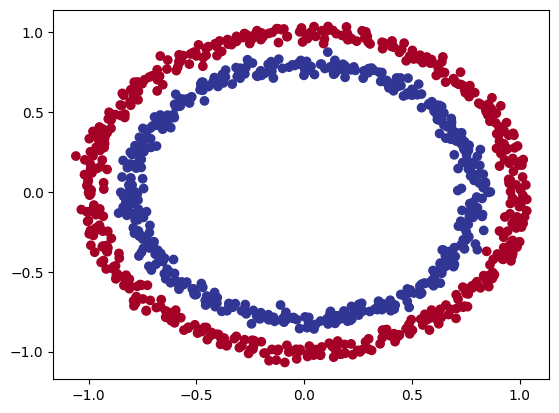

In [131]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=circles["X1"],
            y=circles["X2"],
            c=circles['label'],
            cmap=plt.cm.RdYlBu);

Note: the data we're working with is often referred to as a toy dataset, a dataset enough to experiment but still sizeable enough to practice the fundamentals

### 1.1 Check input and output shapes

In [132]:
X.shape, y.shape

((1000, 2), (1000,))

In [133]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits


In [134]:
# Turn data into tensors
import torch
torch.__version__

'2.0.1+cu118'

In [135]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X.dtype, y.dtype

(torch.float32, torch.float32)

In [136]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [137]:
NEW = [X_train, X_test, y_train, y_test]
for i in NEW:
  print(f"{len(i)}")

800
200
800
200


## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so. we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [138]:
from torch import nn
# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnositc code, let's create a model that:
1. Subclass nn.Module (almost all models in PyTorch subclass nn.Module)
2. Create 2 nn.Linear() layers that are capable of handling shapes of our data
3. Defines a forward() method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target device

In [139]:
# Create a constructor
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 nn linear layers
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer 2

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [140]:
next(model_0.parameters()).device

device(type='cpu')

In [141]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer_2.bias', tensor([-0.2060]))])

In [142]:
# Let's replicate the model above using nn.sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features=5),
    nn.Linear(in_features = 5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [143]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"\nLength of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"\nLength of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predicitions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])

Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predicitions: 
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer



In [144]:
# Set up the loss function
#loss_fin = nn.BCELoss() # BCEloss needs a sigmoid layer
loss_fn = nn.BCEWithLogitsLoss() # Combines BCELoss with sigmoid

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [9]:
# Calculate the accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

### 3.1 Going from raw logits -> prediction probabilities -> predicition labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **predicition labels** by either rounding them or taking the argmax().

In [146]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], grad_fn=<SliceBackward0>)

In [147]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [148]:
# Use sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)[:5]
y_pred_probs, torch.round(y_pred_probs[:5])

(tensor([[0.4916],
         [0.4923],
         [0.5223],
         [0.4827],
         [0.5736]], grad_fn=<SliceBackward0>),
 tensor([[0.],
         [0.],
         [1.],
         [0.],
         [1.]], grad_fn=<RoundBackward0>))

In [149]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.], grad_fn=<SqueezeBackward0>)

In [150]:
# 3. train model
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 100

for epoch in range(epochs):
  ### TRAINING
  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss/ accuracy
  # # nn.BCELoss # expects prediction probabilities as input
  # loss = loss_fn(torch.sigmoid(y_logits),
  #                y_train)

  # nn.BCEWithLogitsLoss
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # optimizer step
  optimizer.step()

  ### TESTING
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate the test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

    # Print out whats happening
    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69796 | Accuracy: 51.88%
Epoch: 10 | Loss: 0.69590 | Accuracy: 51.25%
Epoch: 20 | Loss: 0.69490 | Accuracy: 51.62%
Epoch: 30 | Loss: 0.69435 | Accuracy: 51.12%
Epoch: 40 | Loss: 0.69401 | Accuracy: 50.88%
Epoch: 50 | Loss: 0.69378 | Accuracy: 50.25%
Epoch: 60 | Loss: 0.69362 | Accuracy: 50.00%
Epoch: 70 | Loss: 0.69351 | Accuracy: 50.25%
Epoch: 80 | Loss: 0.69342 | Accuracy: 49.88%
Epoch: 90 | Loss: 0.69336 | Accuracy: 49.88%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isnt learning anything

In [10]:
import requests
from pathlib import Path

# Download helper functions
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping download')
else:
  print("Download helper_functions.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [11]:
from helper_functions import plot_decision_boundary, plot_predictions

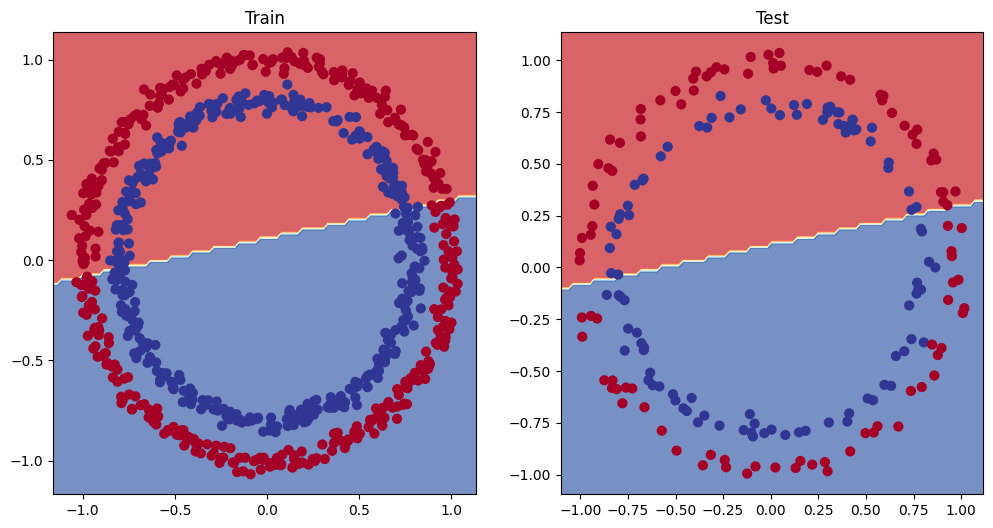

In [153]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving our model (from a models perspective)

* Add more layers
* Add more hidden units
* Fit for longer (increase epochs)
* Changing the activation functions
* Change the learning rate
* Change the loss function

3 things to update our model with:
- Add more hidden units, from 5 -> 10
- Add more layers, from 2->3
- Fit for longer (epochs 100 ->1000)

**NOTE:** For experiment tracking try 1 hyperparameter tuning at a time

In [154]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z
    ### OR
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [155]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [156]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test , y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  ### Train

  # Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)


  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss:{loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Accuracy {test_acc:.2f}")

Epoch: 0 | Loss:0.69713, Acc: 50.00 | Test Loss: 0.69594, Test Accuracy 50.00
Epoch: 100 | Loss:0.69327, Acc: 49.62 | Test Loss: 0.69334, Test Accuracy 54.00
Epoch: 200 | Loss:0.69311, Acc: 49.88 | Test Loss: 0.69357, Test Accuracy 50.00
Epoch: 300 | Loss:0.69305, Acc: 50.62 | Test Loss: 0.69384, Test Accuracy 49.50
Epoch: 400 | Loss:0.69301, Acc: 50.50 | Test Loss: 0.69407, Test Accuracy 46.00
Epoch: 500 | Loss:0.69300, Acc: 51.00 | Test Loss: 0.69425, Test Accuracy 47.50
Epoch: 600 | Loss:0.69299, Acc: 51.50 | Test Loss: 0.69438, Test Accuracy 47.00
Epoch: 700 | Loss:0.69298, Acc: 50.88 | Test Loss: 0.69447, Test Accuracy 46.50
Epoch: 800 | Loss:0.69298, Acc: 51.00 | Test Loss: 0.69453, Test Accuracy 46.00
Epoch: 900 | Loss:0.69298, Acc: 51.50 | Test Loss: 0.69458, Test Accuracy 46.00


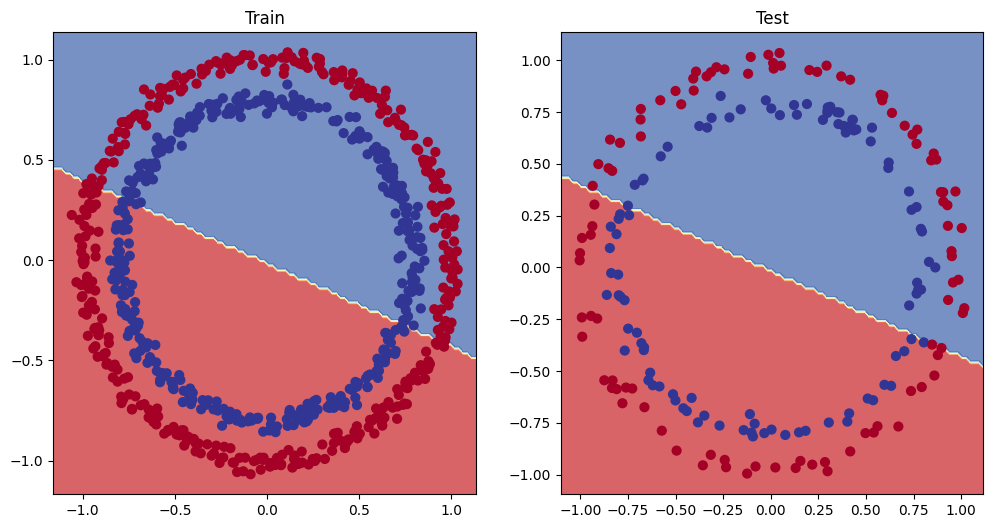

In [157]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [158]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))

100


In [159]:
# Create train test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

NEW = [X_train_regression, y_train_regression, X_test_regression, y_test_regression]
for i in NEW:
  print(len(i))

80
80
20
20


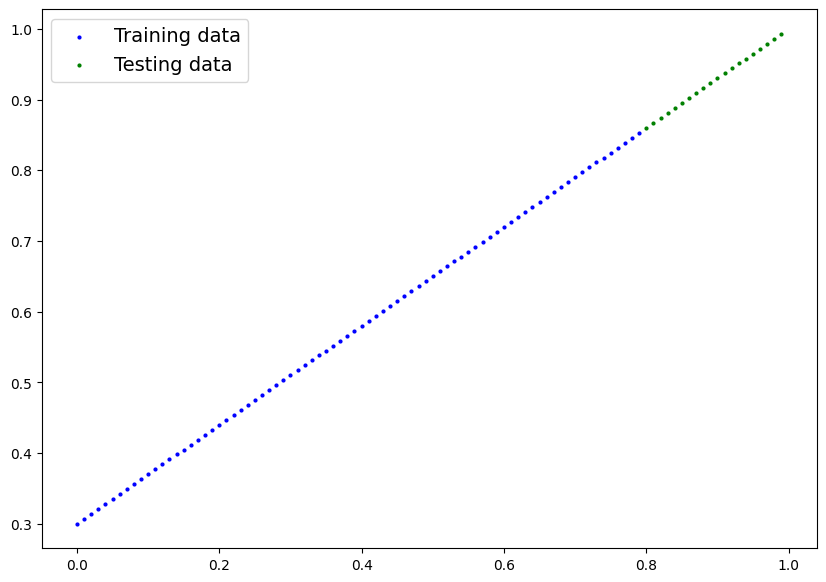

In [160]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

### 5.2 Adjusting model_1 to fit a straight line

In [161]:
# Same architecture as model_1
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [162]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [163]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# # Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # TESTING
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


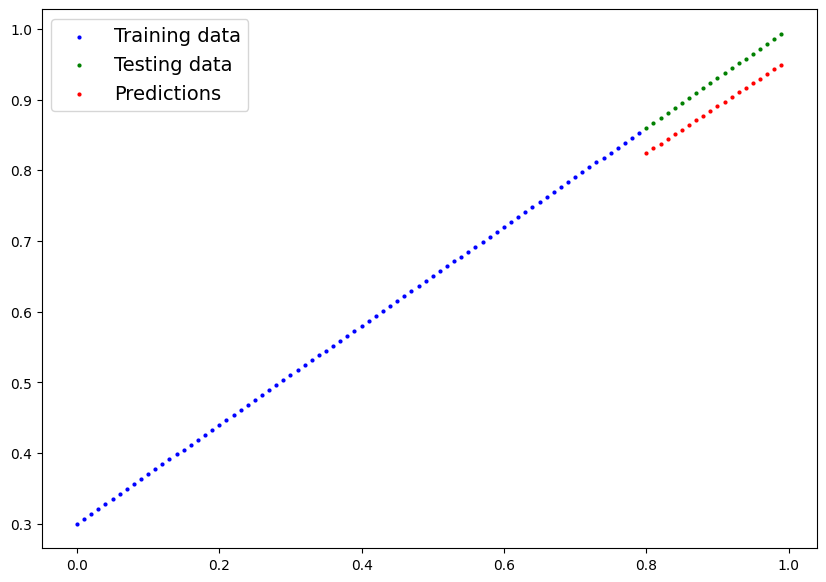

In [164]:
# Turn on evaluation model
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=y_preds);

## 6. The missing piece: non-linearity


### 6.1 Recreating non-linear data (red and blue circles)

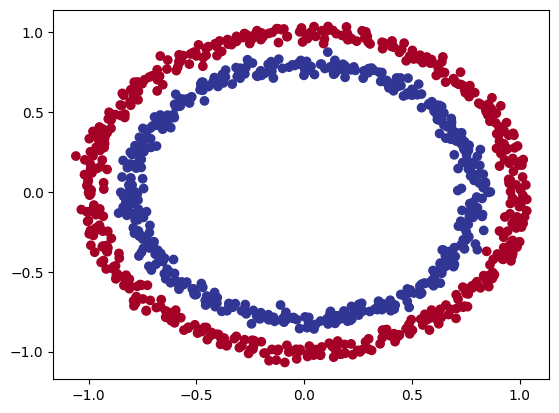

In [165]:
# Make and plot data
import sklearn

from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=circles["X1"],
            y=circles["X2"],
            c=circles['label'],
            cmap=plt.cm.RdYlBu);


In [166]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

### 6.2 Building a model with non-linearity

In [175]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # non-linear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) #Relu between every layer

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [168]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [169]:
# Write a training and evaluation loop for model_3
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test , y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  ### Train
  model_3.train()
  # Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)


  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss:{loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Accuracy {test_acc:.2f}")

Epoch: 0 | Loss:0.69295, Acc: 50.00 | Test Loss: 0.69319, Test Accuracy 50.00
Epoch: 100 | Loss:0.69115, Acc: 52.88 | Test Loss: 0.69102, Test Accuracy 52.50
Epoch: 200 | Loss:0.68977, Acc: 53.37 | Test Loss: 0.68940, Test Accuracy 55.00
Epoch: 300 | Loss:0.68795, Acc: 53.00 | Test Loss: 0.68723, Test Accuracy 56.00
Epoch: 400 | Loss:0.68517, Acc: 52.75 | Test Loss: 0.68411, Test Accuracy 56.50
Epoch: 500 | Loss:0.68102, Acc: 52.75 | Test Loss: 0.67941, Test Accuracy 56.50
Epoch: 600 | Loss:0.67515, Acc: 54.50 | Test Loss: 0.67285, Test Accuracy 56.00
Epoch: 700 | Loss:0.66659, Acc: 58.38 | Test Loss: 0.66322, Test Accuracy 59.00
Epoch: 800 | Loss:0.65160, Acc: 64.00 | Test Loss: 0.64757, Test Accuracy 67.50
Epoch: 900 | Loss:0.62362, Acc: 74.00 | Test Loss: 0.62145, Test Accuracy 79.00


### 6.4 Evaluating the model trained with non-linear activation functions

In [170]:
# Makes predictios
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

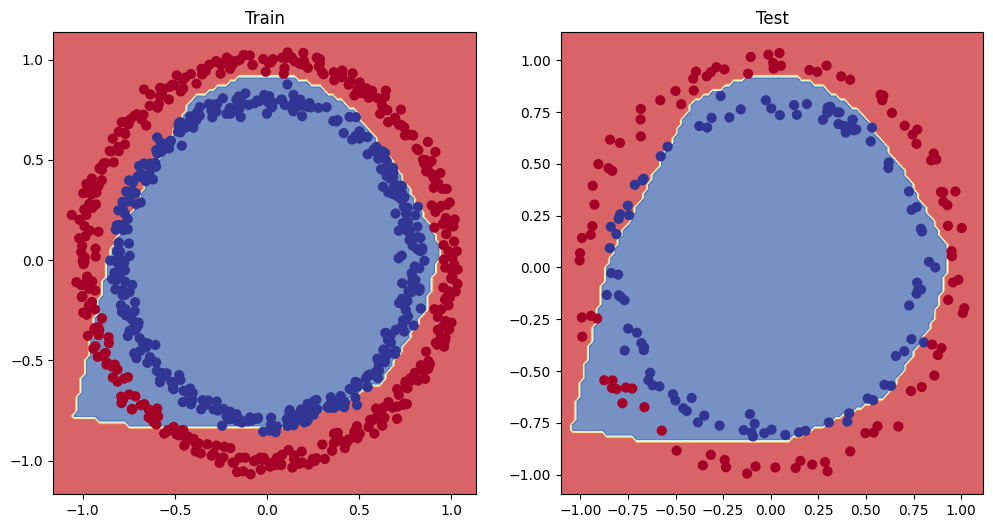

In [171]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

**CHALLENGE** Improve model 3

In [176]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [177]:
# Write a training and evaluation loop for model_3
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test , y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  ### Train
  model_3.train()
  # Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)


  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss:{loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Accuracy {test_acc:.2f}")

Epoch: 0 | Loss:0.69295, Acc: 50.00 | Test Loss: 0.69319, Test Accuracy 50.00
Epoch: 100 | Loss:0.69115, Acc: 52.88 | Test Loss: 0.69102, Test Accuracy 52.50
Epoch: 200 | Loss:0.68977, Acc: 53.37 | Test Loss: 0.68940, Test Accuracy 55.00
Epoch: 300 | Loss:0.68795, Acc: 53.00 | Test Loss: 0.68723, Test Accuracy 56.00
Epoch: 400 | Loss:0.68517, Acc: 52.75 | Test Loss: 0.68411, Test Accuracy 56.50
Epoch: 500 | Loss:0.68102, Acc: 52.75 | Test Loss: 0.67941, Test Accuracy 56.50
Epoch: 600 | Loss:0.67515, Acc: 54.50 | Test Loss: 0.67285, Test Accuracy 56.00
Epoch: 700 | Loss:0.66659, Acc: 58.38 | Test Loss: 0.66322, Test Accuracy 59.00
Epoch: 800 | Loss:0.65160, Acc: 64.00 | Test Loss: 0.64757, Test Accuracy 67.50
Epoch: 900 | Loss:0.62362, Acc: 74.00 | Test Loss: 0.62145, Test Accuracy 79.00
Epoch: 1000 | Loss:0.56818, Acc: 87.75 | Test Loss: 0.57378, Test Accuracy 86.50
Epoch: 1100 | Loss:0.48153, Acc: 93.50 | Test Loss: 0.49935, Test Accuracy 90.50
Epoch: 1200 | Loss:0.37056, Acc: 97.75 |

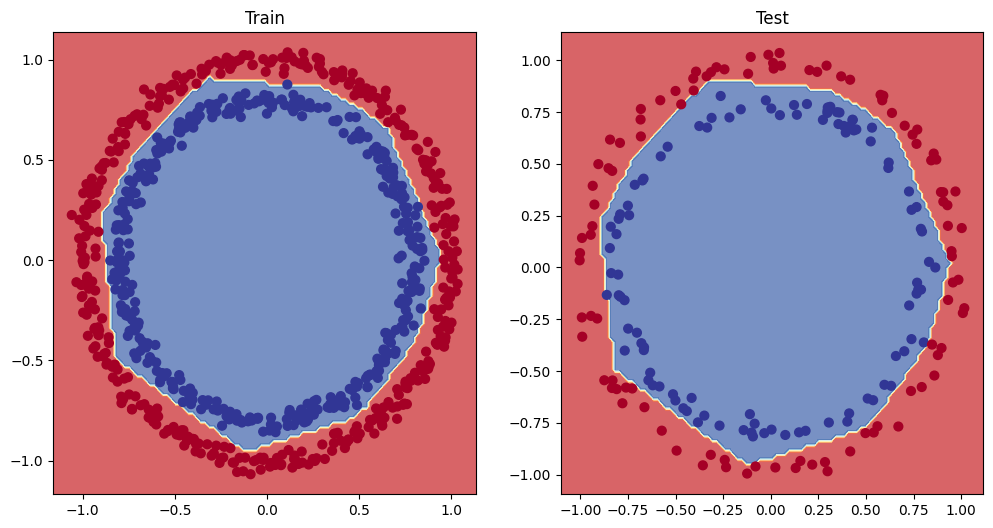

In [178]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 8. Putting it all together with a multi-class classifcation problem



### 8.1 Creating a toy multi-class dataset

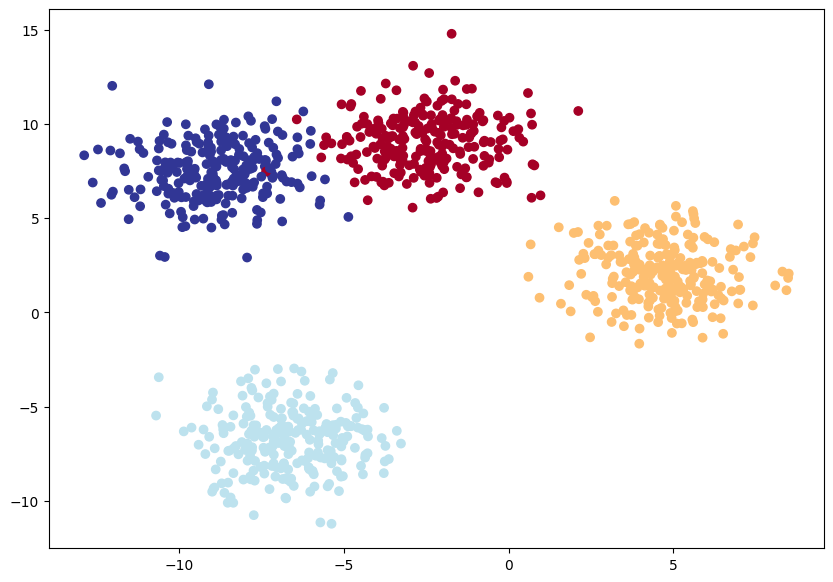

In [12]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float), torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split data into train test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multiclass classification model in PyTorch

In [13]:
# Create a device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
# Build a multiclass classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and optimizer


In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                               lr=0.1)

In [16]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [17]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [18]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

### 8.5 Create training loops

In [23]:
# Fit the multi-class  model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true= y_blob_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

    if epoch % 100 == 0:
      print(f'Epoch: {epoch}, | Loss: {loss:.5f}, Accuracy: {acc:.2f}, | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}')

Epoch: 0, | Loss: 0.02230, Accuracy: 99.25, | Test Loss: 0.01095, Test Accuracy: 99.50
Epoch: 100, | Loss: 0.02207, Accuracy: 99.25, | Test Loss: 0.01073, Test Accuracy: 99.50
Epoch: 200, | Loss: 0.02186, Accuracy: 99.25, | Test Loss: 0.01052, Test Accuracy: 99.50
Epoch: 300, | Loss: 0.02167, Accuracy: 99.38, | Test Loss: 0.01033, Test Accuracy: 99.50
Epoch: 400, | Loss: 0.02147, Accuracy: 99.38, | Test Loss: 0.01015, Test Accuracy: 99.50
Epoch: 500, | Loss: 0.02129, Accuracy: 99.38, | Test Loss: 0.00998, Test Accuracy: 99.50
Epoch: 600, | Loss: 0.02111, Accuracy: 99.50, | Test Loss: 0.00982, Test Accuracy: 99.50
Epoch: 700, | Loss: 0.02094, Accuracy: 99.50, | Test Loss: 0.00966, Test Accuracy: 99.50
Epoch: 800, | Loss: 0.02078, Accuracy: 99.50, | Test Loss: 0.00950, Test Accuracy: 99.50
Epoch: 900, | Loss: 0.02062, Accuracy: 99.50, | Test Loss: 0.00935, Test Accuracy: 99.50


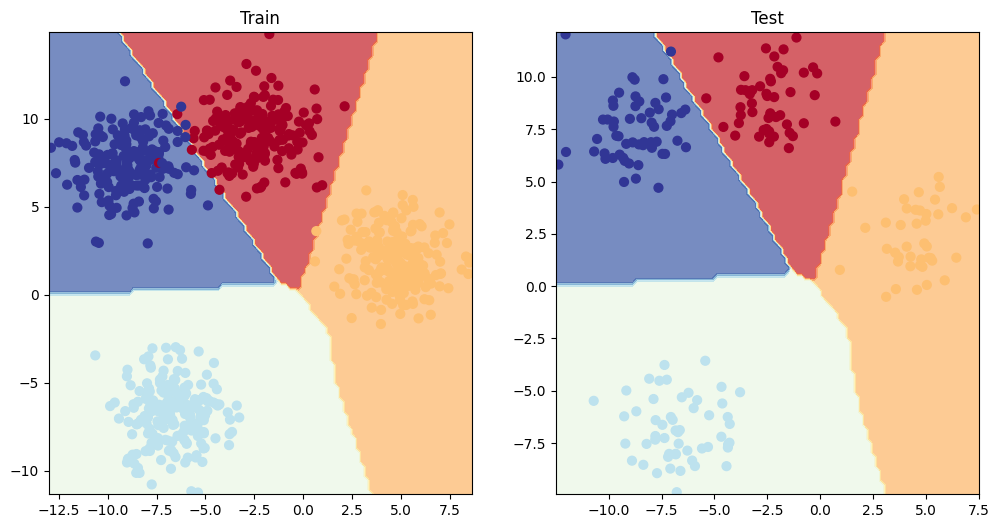

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [ ]:
#!pip install torchmetrics

In [ ]:
# from torchmetrics import Accuracy
# from torchmetrics.classification import MulticlassAccuracy

# # # setup metrics
# torchmetrics_accuracy = MulticlassAccuracy(num_classes=4).to(device)

# # Calculate accuracy
# torchmetrics_accuracy(y_preds, y_blob_test)

In [24]:
# try:
#     from torchmetrics import Accuracy
# except:
#     !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
#     from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.3550)